Downloaded a simple marketing campaign data with experiment and control group for A/B testing

Find answer to following questions:
1. Would the campaign be successful?
2. If the campaign was successful, how much of that success will be attributed to ads.

Data description and downloadable from kaggle: 'https://www.kaggle.com/datasets/faviovaz/marketing-ab-testing/data'

In [37]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [3]:
marketing_data = pandas.read_csv('marketing_AB.csv.zip', compression='zip')

In [4]:
marketing_data.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
3,3,1435133,ad,False,355,Tuesday,10
4,4,1015700,ad,False,276,Friday,14


In [5]:
# Drop Unnamed column
marketing_data = marketing_data.drop(columns=['Unnamed: 0'])
marketing_data.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [6]:
# Check data types in each column
marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 23.0+ MB


In [7]:
# Get summary statistics
marketing_data.describe()

,user id,total ads,most ads hour
count,5.881010e+05,588101.000000,588101.000000
mean,1.310692e+06,24.820876,14.469061
std,2.022260e+05,43.715181,4.834634
min,9.000000e+05,1.000000,0.000000
25%,1.143190e+06,4.000000,11.000000
50%,1.313725e+06,13.000000,14.000000
75%,1.484088e+06,27.000000,18.000000
max,1.654483e+06,2065.000000,23.000000


In [9]:
# Get summary statistics per group
marketing_data.groupby('test group')['total ads'].describe()

,count,mean,std,min,25%,50%,75%,max
test group,,,,,,,,
ad,564577.0,24.823365,43.750456,1.0,4.0,13.0,27.0,2065.0
psa,23524.0,24.761138,42.860720,1.0,4.0,12.0,26.0,907.0


In [10]:
marketing_data.groupby('test group')['most ads hour'].describe()

,count,mean,std,min,25%,50%,75%,max
test group,,,,,,,,
ad,564577.0,14.475900,4.841808,0.0,11.0,14.0,18.0,23.0
psa,23524.0,14.304923,4.656239,0.0,11.0,14.0,18.0,23.0


In [11]:
# Check for missing values
marketing_data.isnull().sum()

user id          0
test group       0
converted        0
total ads        0
most ads day     0
most ads hour    0
dtype: int64

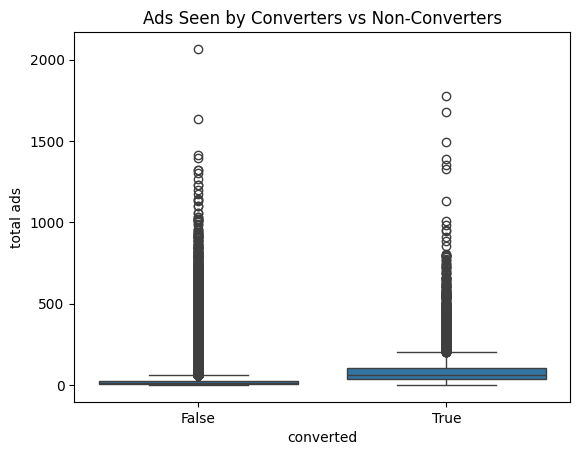

In [12]:
# Check ads seen by converters vs non-converters
sns.boxplot(x='converted', y='total ads', data=marketing_data)
plt.title('Ads Seen by Converters vs Non-Converters')
plt.show()

In [13]:
# Get summary statistics for Ads seen by converters vs non-converters
marketing_data.groupby('converted')['total ads'].describe()

,count,mean,std,min,25%,50%,75%,max
converted,,,,,,,,
False,573258.0,23.291495,40.863176,1.0,4.0,13.0,26.0,2065.0
True,14843.0,83.887759,87.455498,1.0,35.0,64.0,103.0,1778.0


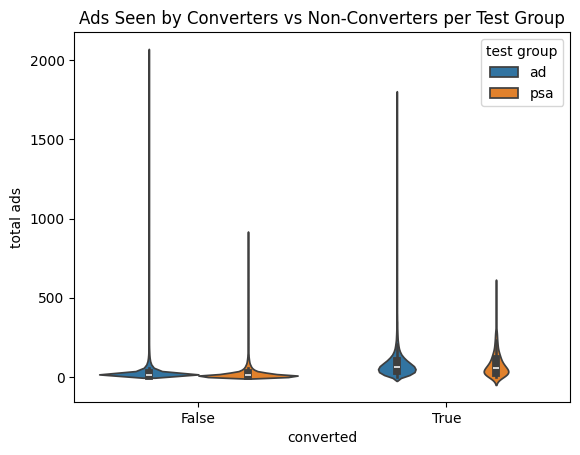

In [15]:
# Check Ads seen by converters vs non-converters per test group
sns.violinplot(x='converted', y='total ads', hue='test group', data=marketing_data)
plt.title('Ads Seen by Converters vs Non-Converters per Test Group')
plt.show()

In [24]:
# Summary statistics for Ads seen by converters vs non-converters per test group
marketing_data['converted'] = marketing_data['converted'].astype(int)
summary_a_b_testing = marketing_data.groupby("test group")["converted"]\
    .agg(['mean', 'count', 'sum', 'std'])\
    .rename(columns={'mean':'conversion_rate', 'sum':'total_conversions', 'count':'users'})
summary_a_b_testing['conversion_rate'] = summary_a_b_testing['conversion_rate'] * 100

In [25]:
print("\nA/B Testing Summary Statistics:\n", summary_a_b_testing)


A/B Testing Summary Statistics:
             conversion_rate   users  total_conversions       std
test group                                                      
ad                 2.554656  564577              14423  0.157778
psa                1.785411   23524                420  0.132424


Calculate Absolute lift and Relative lift

Absolute lift describes direct difference between test group's(ada) conversion rate and control group's(psa) conversion rate.

Relative lift tells how much better ad group performed in comparison to control group

In [26]:
cr_ad = summary_a_b_testing.loc["ad", "conversion_rate"] / 100
cr_psa = summary_a_b_testing.loc["psa", "conversion_rate"] / 100

In [27]:
absolute_lift = cr_ad - cr_psa
relative_lift = (cr_ad - cr_psa) / cr_psa * 100

In [30]:
print(f"\nAbsolute Lift: {absolute_lift:.4f}%")
print(f"Relative Lift: {relative_lift:.2f}%")


Absolute Lift: 0.0077%
Relative Lift: 43.09%


Get confidence intervals for each group

Confidence intervals show the uncertainty of the estimate and help determine if groups are meanigfully different. If CIs of two groups do not overlap, the difference is likely significant. 

In [34]:
ci_ad = proportion_confint(summary_a_b_testing.loc["ad", "total_conversions"], 
                           summary_a_b_testing.loc["ad", "users"], 
                           method='wilson')
ci_psa = proportion_confint(summary_a_b_testing.loc["psa", "total_conversions"], 
                            summary_a_b_testing.loc["psa", "users"], 
                            method='wilson')

In [35]:
print("\n=== 95% CI for Conversion Rates ===")
print(f"Ad group     CI: {ci_ad}")
print(f"PSA group    CI: {ci_psa}")


=== 95% CI for Conversion Rates ===
Ad group     CI: (0.02513821650599992, 0.025961359215123686)
PSA group    CI: (0.016238943989596074, 0.019626711612411318)


CIs of the two groups do not overlap, this suggests difference is likely significant and there is strong evidence that campaign changes conversion

Statistical significance test with Z-test

In [38]:
count = np.array([summary_a_b_testing.loc["ad","total_conversions"], 
                  summary_a_b_testing.loc["psa","total_conversions"]])
nobs = np.array([summary_a_b_testing.loc["ad","users"], 
                 summary_a_b_testing.loc["psa","users"]])

In [39]:
z_stat, p_value = proportions_ztest(count, nobs)

In [40]:
print("\n=== Z-test for difference in proportions ===")
print(f"Z-statistic: {z_stat:.4f}")
print(f"P-value:     {p_value:.6f}")

if p_value < 0.05:
    print("Result: ❗ Statistically significant difference (reject H0)")
else:
    print("Result: ❌ No statistically significant difference")


=== Z-test for difference in proportions ===
Z-statistic: 7.3701
P-value:     0.000000
Result: ❗ Statistically significant difference (reject H0)


Bootstrap confidence interval for lift

Random re-sampling of observed data is performed to ensure robust, data-driven estimate of uncertainty for difference in conversion rates between test and control groups. Advantage of bootstraping:
- Unlike Z-test, it doesn't assume normally distributed metric.
- Bootstrap also works when sample size is small.
- Instead of computing separate CIs for each group and guessing overlap, bootstrap gives a CI for the difference itself
- If conversions are rare (e.g., 1–2%), standard parametric approximations may be inaccurate; bootstrap is more reliable.

In [41]:
def bootstrap_lift(data, group_col, outcome_col, n_boot=5000):
    rng = np.random.default_rng(42)
    diffs = []
    for _ in range(n_boot):
        sample = data.sample(frac=1, replace=True, random_state=rng.integers(1e9))
        cr_ad = sample.loc[sample[group_col]=='ad', outcome_col].mean()
        cr_psa = sample.loc[sample[group_col]=='psa', outcome_col].mean()
        diffs.append(cr_ad - cr_psa)
    return np.percentile(diffs, [2.5, 97.5])

In [43]:
boot_ci_low, boot_ci_high = bootstrap_lift(marketing_data, "test group", "converted")
print("\n=== Bootstrap 95% CI for Lift ===")
print(f"Lift CI: [{boot_ci_low:.4%}, {boot_ci_high:.4%}]")


=== Bootstrap 95% CI for Lift ===
Lift CI: [0.5936%, 0.9387%]


The CI tells us that, based on data and bootstrap resampling, the true lift is likely between 0.5936% and 0.9387%. Since the entire CI is above 0, this suggests that the Ad campaign has a statistically significant positive effect. Even though the lift is statistically significant, the magnitude is less than 1%. If you show ads to 10,000 users:
Extra conversions = 10,000 * 0.005936 ≈ 59 to 10,000 * 0.009387 ≈ 94 conversions
If average order value (AOV) is 50$:
Estimated revenue lift = 59 * 50 ≈ $2,950 to 94 * 50 ≈ $4,685
So the campaign produces modest but positive revenue impact.

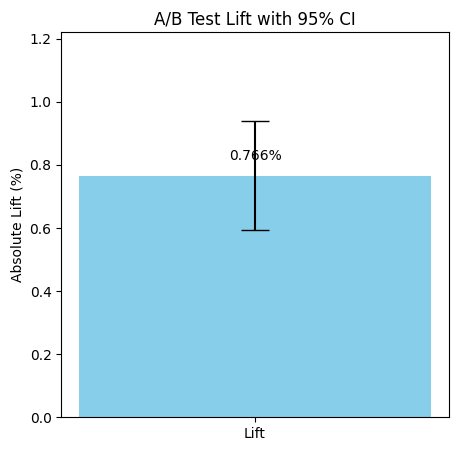

In [44]:
# Plot bootstrap distribution of lift
# Point estimate of lift (in decimal form)
lift_point = 0.7662 / 100  # Example: midpoint or actual lift from your data, convert % to decimal
ci_low = 0.5936 / 100
ci_high = 0.9387 / 100

# Convert to percentage for plotting
lift_point_pct = lift_point * 100
ci_low_pct = ci_low * 100
ci_high_pct = ci_high * 100

plt.figure(figsize=(5,5))
plt.bar(['Lift'], [lift_point_pct], 
        yerr=[[lift_point_pct - ci_low_pct],[ci_high_pct - lift_point_pct]],
        capsize=10, color='skyblue')
plt.ylabel("Absolute Lift (%)")
plt.title("A/B Test Lift with 95% CI")
plt.ylim(0, ci_high_pct*1.3)
plt.text(0, lift_point_pct + 0.05, f"{lift_point_pct:.3f}%", ha='center')
plt.show()